In [42]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import json
import random
import numpy as np
import pandas as pd
import itertools
import scipy
import gc
import cv2

from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import colors as colors_mat
from scipy.ndimage import label, generate_binary_structure
from numpy.lib.stride_tricks import as_strided
from itertools import product
from scipy.spatial.distance import cdist
from scipy.signal import convolve2d
from collections import Counter

In [43]:
start_time = time.time()
print("Load Initial Data ...")

data_path = Path('')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
testing_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
testing_tasks = sorted(os.listdir(testing_path))
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')

print("--- %s seconds ---" % (time.time() - start_time))

Load Initial Data ...
--- 0.0377347469329834 seconds ---


In [44]:
start_time = time.time()
print("Load Data Functions ...")

def flattener(pred):
    
    str_pred = str([row for row in pred.tolist()])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    
    return str_pred

def build_trainlist(task):
    
    task_data = []
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')        
        list.append(task_data, (t_in.copy(), t_out.copy()))
    
    return task_data

def build_testlist(task):
    
    task_data = []
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"]).astype('uint8')       
        list.append(task_data, (t_in.copy()))
    
    return task_data

def load_data(p, phase=None):
    
    if phase in {'training', 'test', 'evaluation'}:
        p = data_path / phase / p
    
    task = json.loads(Path(p).read_text())
    dict_vals_to_np = lambda x: { k : np.array(v) for k, v in x.items() }
    assert set(task) == {'test', 'train'}
    res = dict(test=[], train=[])
    
    for t in task['train']:
        assert set(t) == {'input', 'output'}
        res['train'].append(dict_vals_to_np(t))
    for t in task['test']:
        res['test'].append(dict_vals_to_np(t))
        
    return res

print("--- %s seconds ---" % (time.time() - start_time))

Load Data Functions ...
--- 0.0009801387786865234 seconds ---


In [45]:
start_time = time.time()
print("Load Data Files ...")

train_task_data = []
for i in range(0, 400):
    task = load_data(training_tasks[i], phase='training')
    list.append(train_task_data, task)

eval_task_data = []
for i in range(0, 400):
    task = load_data(evaluation_tasks[i], phase='evaluation')
    list.append(eval_task_data, task)

test_task_data = []
for i in range(0, 100):
    task = load_data(testing_tasks[i], phase='test')
    list.append(test_task_data, task)
    
print("--- %s seconds ---" % (time.time() - start_time))

Load Data Files ...
--- 0.9592599868774414 seconds ---


In [51]:
start_time = time.time()
print("Load Checking Functions")

cmap = colors_mat.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors_mat.Normalize(vmin=0, vmax=9)
num2color = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]
color2num = {c: n for n, c in enumerate(num2color)}

def plot_one(task, ax, i,train_or_test,input_or_output):
    
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+ input_or_output)
    
def plot_task(task):

    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show()

def check_p(task, pred_func):
    
    fig_num = 0
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(3, n, figsize=(4*n,12), dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # All Data for Task
    train_data = build_trainlist(task)
    test_data = build_testlist(task)
    task_data = Task(train_data, test_data)
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')   
        t_pred = t_in
        
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Train-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        fig_num += 1
        
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')
        t_pred = t_in
        
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Test-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        fig_num += 1

print("--- %s seconds ---" % (time.time() - start_time))

Load Checking Functions
--- 0.0019941329956054688 seconds ---


In [52]:
start_time = time.time()
print("Load DSL Helper Functions (Main)")

def get_neighbors(grid, i, j):
    
    nbh = lambda x, i, j: { 
        (ip, jp) : x[i+ip, j+jp] 
            for ip, jp in product([1, -1, 0], repeat=2) 
                if 0 <= i+ip < x.shape[0] and 0 <= j+jp < x.shape[1]
    }
        
    nbh_data = nbh(grid, i, j)
    nbh_values = [(1, 1), (1, -1), (1, 0), (-1, 1), (-1, -1), 
                  (-1, 0), (0, 1), (0, -1), (0, 0)]

    for val in nbh_values:
        if val not in nbh_data:
            nbh_data[val] = 0
    
    return nbh_data

def get_background_color(grid):
    
    try:    
        background_color = 0
        cnt = np.bincount(grid.flatten())[1:]
        bg_color = [i + 1 for i, x in enumerate(cnt) if x == max(cnt)][0]
        if np.nonzero(cnt)[0].shape[0] >= 2:
            if max(cnt) >= (grid.shape[0] * grid.shape[1] * 0.25):
                background_color = bg_color
        return background_color    
    
    except:
        return 0
    
    
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Main)
--- 0.0008127689361572266 seconds ---


In [53]:
start_time = time.time()
print("Load DSL Helper Functions (Detection)")
       
# Ensure No Duplicate Objects
def search_array(arr, arr_data):
    return next((True for elem in arr_data if np.array_equal(elem, arr)), False)

# Separate Objects by Distance
def object_detection_1(grid):
    
    # List of Objects
    object_list = []
    grid_copy = grid.copy()
    struct = generate_binary_structure(2, 2)
    labels, num_labels = label((grid_copy != 0), structure=struct)

    # Find Objects
    for i in range(0, num_labels):
        idx = np.column_stack(np.where(labels == i + 1))
        x_min = min([point[0] for point in idx])
        y_min = min([point[1] for point in idx])
        x_max = max([point[0] for point in idx])
        y_max = max([point[1] for point in idx])

        object_data = {}
        object_data['coords'] = idx
        object_data['obj'] = grid_copy[x_min: x_max + 1, y_min: y_max + 1]
        list.append(object_list, object_data)

    return object_list
        
# Separate Objects by Color/Distance
def object_detection_2(grid):
    
    # List of Objects
    object_list = []
    grid_copy = grid.copy()
    struct = generate_binary_structure(2, 2)
    
    # Ensure Colors != Background
    grid_colors = np.unique(grid_copy)
    bg_color = get_background_color(grid_copy)
    grid_colors = [col for col in grid_colors if col not in [0, bg_color]]

    # Find Objects
    for color in grid_colors:
        labels, num_labels = label((grid_copy == color), structure=struct)
        for i in range(0, num_labels):
            idx = np.column_stack(np.where(labels == i + 1))
            x_min = min([point[0] for point in idx])
            y_min = min([point[1] for point in idx])
            x_max = max([point[0] for point in idx])
            y_max = max([point[1] for point in idx])

            object_data = {}
            object_data['coords'] = idx
            object_data['obj'] = grid_copy[x_min: x_max + 1, y_min: y_max + 1]
            list.append(object_list, object_data)
        
    return object_list

# Separate Layers in grid
def layer_detection(grid):
    
    # List of Layers
    layer_list = []
    grid_copy = grid.copy()
    grid_colors = np.unique(grid_copy)

    # Find Layers by Color
    for color in grid_colors:
        layer_copy = grid_copy.copy()
        layer_copy[layer_copy != color] = 0
        
        idx = []
        for i in range(0, grid_copy.shape[0]):
            for j in range(0, grid_copy.shape[1]):
                list.append(idx, [i, j])

        layer_data = {}
        layer_data['coords'] = np.array(idx)
        layer_data['obj'] = layer_copy
        list.append(layer_list, layer_data)
        
    return layer_list
      
# Separate Regions in grid
def region_detection(grid):
    
    # List of Regions
    region_list = []
    grid_copy = grid.copy()

    # Ensure Colors != Background
    grid_colors = np.unique(grid_copy)
    bg_color = get_background_color(grid_copy)
    grid_colors = [col for col in grid_colors if col not in [0, bg_color]]
    
    # Find Regions by Looking for Horizontal/Vertical Lines
    # Typically, there won't be any overlap between region lines/object colors
    for color in grid_colors:
        
        # Declare Splits
        vertical_splits = None
        horizontal_splits = None

        # Vertical Regions
        vertical_partition = np.zeros((grid_copy.shape[0], 1))       
        vertical_partition[:, 0] = color
        vertical_result = cv2.matchTemplate(
            grid_copy.astype(np.uint8), vertical_partition.astype(np.uint8), cv2.TM_SQDIFF)
        vertical_positions = np.argwhere(vertical_result < 0.001)

        # Horizontal Regions
        horizontal_partition = np.zeros((1, grid_copy.shape[1]))       
        horizontal_partition[0, :] = color
        horizontal_result = cv2.matchTemplate(
            grid_copy.astype(np.uint8), horizontal_partition.astype(np.uint8), cv2.TM_SQDIFF)
        horizontal_positions = np.argwhere(horizontal_result < 0.001)
                
        # Check if Horizontal/Vertical Partitions Exist
        if (len(vertical_positions) >= 1) or (len(horizontal_positions) >= 1):
            
            # Combine Vertical/Horizontal Regions
            vertical_splits = [-1] + [x[1] for x in vertical_positions]
            horizontal_splits = [-1] + [x[0] for x in horizontal_positions]
            
            # Get Vertical Split Ranges
            for i, v_split in enumerate(vertical_splits):
                end_split_i = None
                start_split_i = vertical_splits[i]
                if i + 1 == len(vertical_splits):
                    end_split_i = grid_copy.shape[1]
                else:
                    end_split_i = vertical_splits[i + 1]

                # Get Horizontal Split Ranges
                for j, h_split in enumerate(horizontal_splits): 
                    end_split_j = None
                    start_split_j = horizontal_splits[j]
                                        
                    if j + 1 == len(horizontal_splits):
                        end_split_j = grid_copy.shape[0]
                    else:
                        end_split_j = horizontal_splits[j + 1]
                    
                    idx = []
                    for i in range(start_split_i + 1, end_split_i):
                        for j in range(start_split_j + 1, end_split_j):
                            list.append(idx, [i, j])

                    region_data = {}
                    region_data['coords'] = np.array(idx)
                    region_data['obj'] = grid_copy[start_split_j + 1: end_split_j, start_split_i + 1: end_split_i]
                    list.append(region_list, region_data)

    return region_list
         
# Separate Object in grid
def object_detection(grid):
    
    # List of Objects
    combined_objects = []
    
    # Run Object Detection (1)
    obj1 = object_detection_1(grid)    
    for object_ in obj1:
        current_objects = [object_data["obj"] for object_data in combined_objects]
        if not search_array(object_["obj"], current_objects):
            combined_objects.append(object_)

    # Run Object Detection (2)
    obj2 = object_detection_2(grid)
    for object_ in obj2:
        current_objects = [object_data["obj"] for object_data in combined_objects]
        if not search_array(object_["obj"], current_objects):
            combined_objects.append(object_)

    # Calculate Layers/Regions
    layers = layer_detection(grid)
    regions = region_detection(grid)

    # Check Layers for Unique Objects
    for layer in layers:
        
        # Run Object Detection (3)
        obj1 = object_detection_1(layer["obj"])
        for object_ in obj1:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

        # Run Object Detection (4)
        obj2 = object_detection_2(layer["obj"])
        for object_ in obj2:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

    # Check Regions for Unique Objects
    for region in regions:
        
        # Run Object Detection (3)
        obj1 = object_detection_1(region["obj"])                
        for object_ in obj1:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

        # Run Object Detection (4)
        obj2 = object_detection_2(region["obj"])
        for object_ in obj2:
            current_objects = [object_data["obj"] for object_data in combined_objects]
            if not search_array(object_["obj"], current_objects):
                combined_objects.append(object_)

    return combined_objects
    
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Detection)
--- 0.0029060840606689453 seconds ---


In [54]:
start_time = time.time()
print("Load DSL Helper Functions (Entity)")

# Fundamental Entity (Tensors, Objects, etc). 
# Contains all Basic Methods acting on Task Samples.
class Entity():
    
    def __init__(self, grid):
        self.grid = grid
                
    def compute_attributes(self):
        pass
        
# Extends Entity Class
# Contains Data for Sections of grid
class Section(Entity):
    
    def __init__(self, section_data):
        super().__init__(section_data["obj"])
        self.coords = section_data["coords"]
            
    def compute_attributes(self):
        super().compute_attributes()

# Extends Entity Class
# Contains Entire Data for Input/Output
class Tensor(Entity):
    
    def __init__(self, grid):
        super().__init__(grid)
        self.objects = []
        self.layers = []
        self.regions = []
        self.compute_features()
        self.compute_attributes()
        
    def compute_features(self):
        object_data = object_detection(self.grid)
        layer_data = layer_detection(self.grid)
        region_data = region_detection(self.grid)
    
        for object_ in object_data:
            section = Section(object_)
            section.compute_attributes()
            list.append(self.objects, section)
        for layer_ in layer_data:
            section = Section(layer_)
            section.compute_attributes()
            list.append(self.layers, section)
        for region_ in region_data:
            section = Section(region_)
            section.compute_attributes()
            list.append(self.regions, section)
                
    def compute_attributes(self):
        super().compute_attributes()           

# Fundamental Class for ALL Tasks
# Contains all Basic Methods acting on Tasks.
class Task():
    
    def __init__(self, train_data, test_data):
        
        # Lists of Train/Test Tensors
        self.train_tensors = []
        self.test_tensors = []
        
        # Compute Train/Test Tensors
        for t_in, t_out in train_data:
            tensor_in = Tensor(t_in)
            tensor_out = Tensor(t_out)
            list.append(self.train_tensors, [tensor_in, tensor_out])
        for t_in in test_data:
            tensor_in = Tensor(t_in)
            list.append(self.test_tensors, [tensor_in])
        
        # Compute Attributes 
        # self.compute_diff_attributes()
        # self.find_common_diff()
        # self.find_sequence()
                
    # Compute Attribute Differences
    def compute_diff_attributes(self):
        pass
        
    # Find Common Differences in Input/Output Pairs
    def find_common_diff(self, train_attr):
        pass
        
    # Find Sequences in Common Differences
    def find_sequence(self, train_attr):
        pass
                               
print("--- %s seconds ---" % (time.time() - start_time))

Load DSL Helper Functions (Entity)
--- 0.0014841556549072266 seconds ---


Testing DSL Coverage (Manual) ...
--- 0.44074392318725586 seconds ---


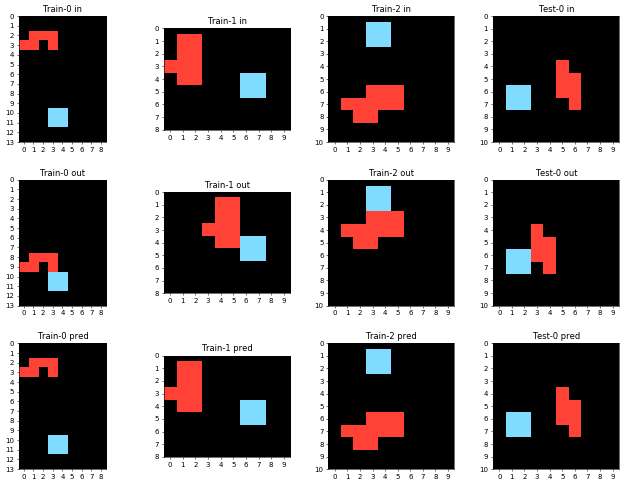

In [55]:
start_time = time.time()
print("Testing DSL Coverage (Manual) ...")

def combine_tasks(a, features):
    b = a.copy()
    return b

tasks_indices = [7]
for task in tasks_indices:
    check_p(train_task_data[task], combine_tasks)

print("--- %s seconds ---" % (time.time() - start_time))